In [1]:
%cd ..

/mnt/c/Users/XCB/OneDrive - Van Oord/Documents/thesis/code


In [2]:
from atl_module import GebcoUpscaler
import pandas as pd

In [3]:
sitename = "stcroix"
site = GebcoUpscaler(
    f"../data/test_sites/{sitename}",
    "TEST IGNORE",
    f"../data/test_sites/{sitename}/in-situ-DEM/truth.vrt",
)

plotting photon map
finished plotting photons
finished adding basemap


[I 220930 15:46:07 core:368] Photon output written to ../document/figures/TEST IGNORE_photon_map.pdf


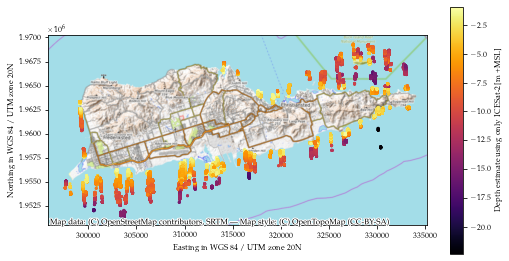

In [4]:
fig = site.plot_icesat_points()

In [5]:
ax1 = fig.axes[0]
collection = ax1.collections[0]
collection.colorbar

In [6]:
from matplotlib import cm

fig.colorbar(cm.ScalarMappable(), ax=ax1, fraction=0.046)

In [7]:
# from itertools import product
# # setup result dictionary
# result = {}
# # make an empty list for each result
# result['window']=[]
# result['perc_hconf']=[]
# result['min_kde']=[]
# result['rmse']=[]
# result['MAE']=[]

# # loop over the inner product of the
# for window,perc_h,kde_min in product([100,150,200],[20,40,60],[0.0,0.1,0.2]):
#     result['window'].append(window)
#     result['perc_hconf'].append(perc_h)
#     result['min_kde'].append(kde_min)
#     site.find_bathy_from_icesat(
#     window=window,
#     threshold_val=0.0,
#     req_perc_hconf=perc_h,
#     window_meters=None,
#     min_photons=None,
#     min_kde=kde_min,
#     save_result=False
#     )
#     site.lidar_rmse()
#     result['rmse'].append(site.rmse_icesat)
#     result['MAE'].append(site.mae_icesat)
#     print(result)

# pd.DataFrame(result).to_csv(f'../data/test_sites/{site.site}/error_stats.csv')

In [8]:
site.plot_lidar_error()

AttributeError: 'GebcoUpscaler' object has no attribute 'lidar_err_dict'

In [ ]:
# site.bathy_pts_gdf = site.bathy_pts_gdf.assign(z_kde = site.bathy_pts_gdf.z_kde - site.bathy_pts_gdf.dac_corr  + site.bathy_pts_gdf.tide_ocean_corr)

In [ ]:
%%time
site.kriging(
    npts=1600,
    kr_model="uk",
    samplemethod="dart",
    # variogram_parameters={'range':33000,'nugget':0.7,'sill':23},
)

In [ ]:
site.kalman_update(2)
site.raster_rmse()

In [ ]:
date_indexed_tracklines = (
    site.tracklines.assign(date=pd.to_datetime(site.tracklines.date).dt.date)
    .reset_index()
    .set_index(["date", "beam"])
)
df = (
    site.bathy_pts_gdf.groupby(
        [
            pd.to_datetime(
                site.bathy_pts_gdf.rename(columns={"delta_time": "date"}).date
            ).dt.date,
            "beam",
        ]
    )
    .mean()
    .sort_values("error", ascending=False)
)
#
df = df.merge(date_indexed_tracklines, how="left", left_index=True, right_index=True)

In [ ]:
from atl_module.geospatial_utils.raster_interaction import query_raster

noNA = site.bathy_pts_gdf.loc[:, ["X", "Y", "sf_elev_MSL", "true_elevation"]].dropna()
krigedvalue = query_raster(noNA, f"../data/test_sites/{sitename}/kriging_output.tif")
noNA = noNA.assign(krigedval=krigedvalue).dropna()

In [ ]:
ax = noNA.plot.scatter(x="sf_elev_MSL", y="krigedval", figsize=(10, 10))
ax.plot((-14, 0), (-14, 0), color="r")

In [ ]:
sqaured_error = (noNA.sf_elev_MSL.values - noNA.krigedval.values) ** 2
rms_icesat_kriging = sqaured_error.mean() ** 0.5
print(f"RMSE error bt icesat and kriged raster: {rms_icesat_kriging}")

In [ ]:
sqaured_error = (noNA.true_elevation.values - noNA.krigedval.values) ** 2
rms_truth_kriging = sqaured_error.mean() ** 0.5
print(f"RMSE error bt kriged raster and true elevation: {rms_truth_kriging}")

In [ ]:
site.bathy_pts_gdf.plot.scatter(x="error", y="true_elevation")

In [ ]:
site.bathy_pts_gdf.plot.scatter(x="error", y="sea_level_interp")

In [ ]:
site.bathy_pts_gdf.plot.scatter(x="error_abs", y="kde_val")

In [ ]:
site.bathy_pts_gdf.plot.scatter(x="error_abs", y="gebco_elev")

In [ ]:
site.bathy_pts_gdf.plot.scatter(x="error_abs", y="ph_count")

In [ ]:
df.plot.scatter(y="error_abs", x="oc_sig_conf")

In [ ]:
df.plot.scatter(y="error_abs", x="oc_hconf_perc")

In [ ]:
df.plot.scatter(y="error_abs", x="secchi_dep")

In [ ]:
df.plot.scatter(y="error_abs", x="tide_ocean_corr")

In [ ]:
df.plot.scatter(y="error_abs", x="dac_corr")

In [ ]:
df.plot.scatter(y="error_abs", x="ph_count")

In [ ]:
df.plot.scatter(y="error_abs", x="kde_val")

In [ ]:
df.plot.scatter(y="error_abs", x="sea_level_interp")

In [ ]:
site.bathy_pts_gdf.groupby("beamtype").mean()

In [ ]:
site.bathy_pts_gdf = site.bathy_pts_gdf.eval("ph_count = abs(ph_count)")
site.bathy_pts_gdf.corr("spearman")["error"].sort_values()

In [ ]:
df.corr()["error"].sort_values()

In [ ]:
site.bathy_pts_gdf[site.bathy_pts_gdf.Z_geoid > -50].dropna().error.pow(2).mean() ** (
    0.5
)

In [ ]:
site.bathy_pts_gdf.error.mean()

In [ ]:
dac_tide = (
    site.bathy_pts_gdf.z_kde
    - site.bathy_pts_gdf.dac_corr
    - site.bathy_pts_gdf.tide_ocean_corr
)
site.bathy_pts_gdf.assign(dac_tide=dac_tide).eval(
    "error=dac_tide - true_elevation"
).error.pow(2).mean() ** (0.5)

In [ ]:
site.bathy_pts_gdf.assign(dac_tide=dac_tide).error.mean()

In [ ]:
site.bathy_pts_gdf[site.bathy_pts_gdf.Z_geoid > -50].sea_level_interp

## 